In [5]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp
from scipy.stats import chi2_contingency

SAVE_FIGURES = False
x_points = 10
TRIALS = 10

In [6]:
palettes = (('rocket_r', ['pearson', 'spearman', 'kendall']), ('mako', ['tau2p < 0.05', 'complexity']))


def generate(y_func, obs_range, noise=None, trials=None, boost=None):
    data, ecs = [], []
    
    # generate data
    for o in obs_range:
        for t in range(trials):
            x = np.random.random(o)
            
            # generate y incl noise
            y = y_func(x, o)
            if noise is not None:
                y = y + np.random.normal(0, noise, len(y))
            
            # generate metrics
            ec = ep.ErgodicCorrelation(x, y, tau_boost=boost)
            mt = ec.correlations
            mt['observations'] = o
            mt['trial'] = t
            mt['noise'] = 0 if noise is None else noise
            mt['tau2p < 0.05'] = 1.0 if mt['tau2p'] < 0.05 else 0.0
            data.append(mt)
            ecs.append(ec)
    
    return data, ecs

def noise_plot(y_func, noise=ep.binspace(0.05, 1.5, 20), name=None, trials=TRIALS, boost=None):
    datasets = []
    for n in noise:
        nbsetup.cp(n)
        data, ecs = generate(y_func, obs_range=[100,1000,3000], noise=n, trials=trials, boost=boost)
        datasets = datasets + data
    
    # relationships
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    df = pd.DataFrame(datasets)
    df = df.melt(id_vars=['observations', 'trial','noise'])
    
    # first graph
    for palette, variables in palettes:
        g = sns.lineplot(data=df[df['variable'].isin(variables)],
                     x='noise', y='value', hue='variable', palette=palette, ax=axes[0])
    g.set_title('Metrics against noise (%s)' % name)
    g.set(ylim=(0,1))
    
    # second graph
    g = sns.lineplot(data=df[df['variable'] == 'tau2p < 0.05'],
                     x='noise', y='value', hue='observations', palette='Spectral', ax=axes[1])
    g.set(ylim=(0,1))
    
    if SAVE_FIGURES:
        fig.savefig('figures/%s.eps' % name)
    return fig

1.5


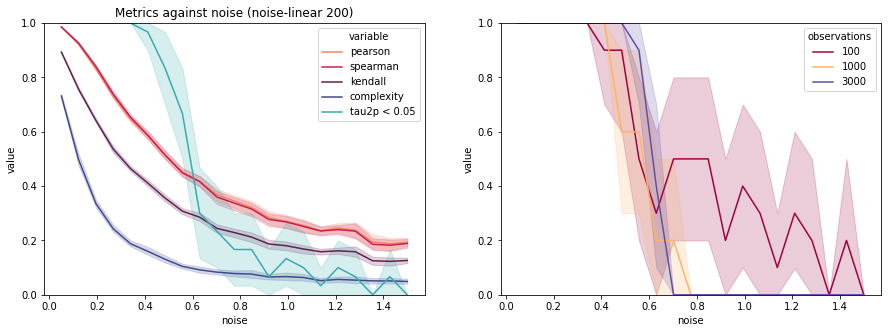

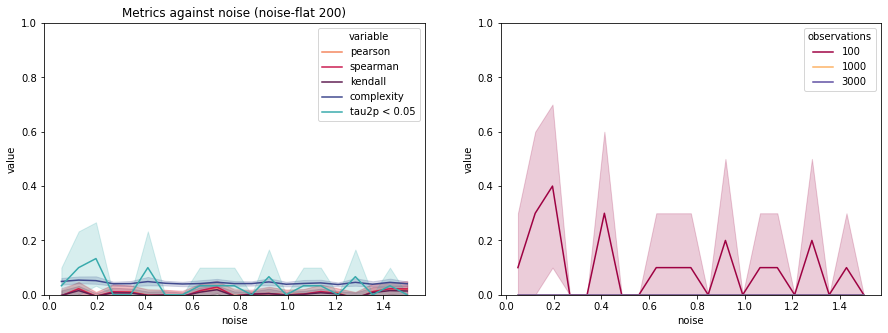

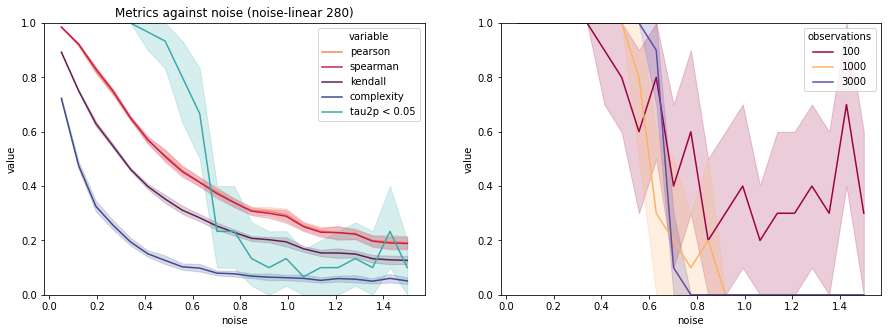

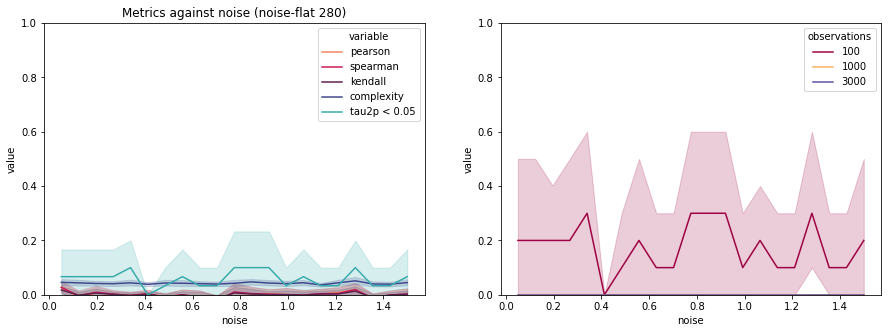

In [6]:
for boost in [200,280]:
    linear_noise = noise_plot(lambda x,o: x, name='noise-linear %s' % boost, boost=boost)
    flat_noise = noise_plot(lambda x,o: np.ones(o), name='noise-flat %s' % boost, boost=boost)